In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import pandas as pd
from ClusterAndPredict.ClusterAndPredict import ClusterAndPredict
from sklearn.model_selection import GridSearchCV
import chromadb
from Testing.DataLoader import DataLoader

Parameters to adjust
UMAP - n_neighbors, min_dist (0 - 0.1), metric (cosine)
HDBSCAN - min_cluster_size, min_samples

Metrics to consider
Accuracy

TRACK The Results

In [41]:
chroma_client = chromadb.PersistentClient(path="/Users/vinayakkannan/Desktop/Projects/FactChecker/FactChecker/Clustering/Clustering/Chroma")
# Count number of collections
print(chroma_client.count_collections())

# Get all collection names
collection_names = chroma_client.list_collections()

# Loop through each collection and drop it
for collection_name in collection_names:
    if collection_name.name != 'climate_claims_embeddings_unchanged':
        chroma_client.delete_collection(collection_name.name)

23


In [4]:
data_loader = DataLoader(0.5)
train_df, test_df = data_loader.create_large_train_test_df()

TypeError: DataLoader.create_large_train_test_df() missing 1 required positional argument: 'remove_synthetic_data'

In [5]:
train_df['Numerical Rating'].value_counts()

NameError: name 'train_df' is not defined

In [6]:
# value count of train_df for each 'Category' and 'Numerical Rating'
test_df['Numerical Rating'].value_counts()

NameError: name 'test_df' is not defined

In [42]:
parameters = {
    'min_cluster_size': [10],
    'min_samples': [10],
    # 'n_neighbors': [int(train_df.shape[0] - 2) * 0.15], #[400],
    'min_dist': [0.1],
    'num_components': [100],
    'no_umap': [False],
    'k': [15],
    'supervised_umap': [True],
    'parametric_umap': [False],
    'claim_column_name': ['Text'],
    'veracity_column_name': ['Numerical Rating'],
    'supervised_label_column_name': ['Numerical Rating'],
    'random_seed': [True],
    'use_weightage': [True],
}

In [ ]:
percentages = [0.5]
results = []
for percentage in percentages:
    data_loader = DataLoader(percentage)
    # train_df, test_df = data_loader.create_train_test_df(False, True, True)
    # train_df, test_df = data_loader.create_large_train_test_df(remove_synthetic_data=True)
    train_df, test_df = data_loader.create_matched_large_df(False)
    # Sample 0.05 of the data
    # train_df = train_df.sample(frac=0.05)
    # test_df = test_df.sample(frac=0.05)
    cluster_predict_object = ClusterAndPredict(train_df=train_df)
    # Parallelism with jobs doesnt work
    parameters['n_neighbors'] = [int(train_df.shape[0] - 2)]
    clf = GridSearchCV(cluster_predict_object, parameters, verbose=1, cv=2, refit=True)
    clf.fit(test_df['Text'].tolist(), test_df['Numerical Rating'].tolist())
    # Print best parameters
    best_estimator: ClusterAndPredict = clf.best_estimator_
    output = {
        'percentage': percentage,
        'best_params': clf.best_params_,
        'best_score': clf.best_score_,
        'accuracy': best_estimator.get_accuracy(),
        'was_supervised_umap_used': best_estimator.get_was_supervised(),
        'metrics': best_estimator.get_all_performance_metrics(),
    }
    print(output)
    results.append(output)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/Users/vinayakkannan/Desktop/Projects/FactChecker/FactChecker/venv2/lib/python3.11/site-packages/pynndescent/pynndescent_.py:962: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(


In [37]:
object_output = best_estimator.get_all_performance_metrics()
cluster_df = object_output['cluster_df']
# Print unique count of 'cluster'
cluster_df['cluster'].nunique()

['Said of the National Climate Assessment: "And you have to look at the fact that this report is based on the most extreme modeled scenario."'
 'Said of the National Climate Assessment: "And you have to look at the fact that this report is based on the most extreme modeled scenario."']
[1. 1.]
Yeah this shouldn't happen lol
['Greenhouse effect is a hoax, global warming uncorrelated with CO2 levels'
 'Greenhouse effect is a hoax, global warming uncorrelated with CO2 levels']
[1. 1.]
Yeah this shouldn't happen lol
['Spain’s minister for ecological transition and demographic challenge, Teresa Ribera, travelled to a climate conference by private jet.'
 'Spain’s minister for ecological transition and demographic challenge, Teresa Ribera, travelled to a climate conference by private jet.']
[1. 1.]
Yeah this shouldn't happen lol
['"30,000 scientists have come forward confirming that man-made climate change is a hoax perpetuated by the elite in order to make money."'
 '"30,000 scientists have 

11

In [9]:
# Rename 'text' column in cluster_df to 'Text'
cluster_df = cluster_df.rename(columns={'text': 'Text'})
train_df, test_df = data_loader.create_large_train_test_df(False)
# Join the 'Synthetic' column in train_df and test_df on cluster_df using the 'text' column
# Concatenate train_df and test_df
combined_df = pd.concat([train_df, test_df])

# Ensure that 'Text' column is of the same data type in both dataframes
combined_df['Text'] = combined_df['Text'].astype(str)
cluster_df['Text'] = cluster_df['Text'].astype(str)

# Merge 'Synthetic' column from combined_df to cluster_df
cluster_df = cluster_df.merge(combined_df[['Text', 'Synthetic']], on='Text', how='left')

Numerical Rating
3    5158
1     402
Name: count, dtype: int64
Numerical Rating
3    5157
1     403
Name: count, dtype: int64


In [38]:
cluster_df

,text,veracity,predict,embeddings,cluster,predicted_veracity,num_correct_in_cluster,total_in_cluster,cluster_accuracy
0,"Said of the National Climate Assessment: ""And ...",1.0,True,"[1.2157729864120483, 9.680440902709961, 4.9769...",-1,4.0,470,569,0.826011
1,"Greenhouse effect is a hoax, global warming un...",1.0,True,"[1.171416997909546, 9.694263458251953, 5.00755...",12,1.0,26,26,1.000000
2,Spain’s minister for ecological transition and...,1.0,True,"[1.3434456586837769, 9.884533882141113, 4.8615...",-1,4.0,470,569,0.826011
3,"""30,000 scientists have come forward confirmin...",1.0,True,"[1.3134266138076782, 9.653348922729492, 4.9968...",-1,4.0,470,569,0.826011
4,Sky News published an article that says vaccin...,1.0,True,"[1.3298743963241577, 9.775714874267578, 4.9629...",-1,4.0,470,569,0.826011
...,...,...,...,...,...,...,...,...,...
762,“The reality is more people are dying of bad c...,1.0,False,"[1.2670339345932007, 9.894373893737793, 5.1771...",-1,1.0,470,569,0.826011
763,“We have been cooling down for the past 4000 y...,1.0,False,"[1.06821870803833, 9.75129222869873, 5.0348243...",13,1.0,15,15,1.000000
764,“… 600 million Africans lack access to electri...,3.0,False,"[1.309965968132019, 9.540392875671387, 4.71548...",-1,3.0,470,569,0.826011
765,“… with 93% of that power being renewable.”,1.0,False,"[1.2300374507904053, 9.86239242553711, 5.00887...",-1,1.0,470,569,0.826011


In [10]:
# Filter out 4 from cluster_df
cluster_df = cluster_df[cluster_df['predicted_veracity'] != 4.0]
cluster_df = cluster_df[cluster_df['predicted_veracity'] != 5.0]
cluster_df = cluster_df[cluster_df['cluster'] != -1]
# Filter cluster_df to be the first row per cluster
clusters_unique = cluster_df.groupby('cluster').first().reset_index()
# Calculate the cutoff for the top 50% of clusters by count
cutoff = clusters_unique['total_in_cluster'].quantile(0.5)
# Filter the clusters that are in the top 50%
top_clusters = clusters_unique[clusters_unique['total_in_cluster'] > cutoff]
# Get the top 10 lowest 'cluster_accuracy' clusters
top_clusters = top_clusters.nsmallest(10, 'cluster_accuracy', keep='all')
# Filter cluster_df to be the top clusters
top_cluster_df = cluster_df[cluster_df['cluster'].isin(top_clusters['cluster'])]
top_cluster_df

,Text,veracity,predict,embeddings,cluster,predicted_veracity,num_correct_in_cluster,total_in_cluster,cluster_accuracy,Synthetic
54,Even climate scientists who believe that man i...,1.0,True,"[16.75649642944336, 7.302152633666992, 8.66819...",78,3.0,12,28,0.428571,False
239,in a time when CO2 emissions were rising stron...,1.0,True,"[16.768678665161133, 7.143996238708496, 8.9121...",15,3.0,12,29,0.413793,False
248,We know this because observations over the las...,1.0,True,"[16.84231948852539, 7.284847259521484, 8.87673...",153,3.0,12,21,0.571429,False
271,"The climate alarmists, says Carlin, have now b...",1.0,True,"[16.71180534362793, 7.290363788604736, 8.84081...",15,3.0,12,29,0.413793,False
286,"However, proof of global warming is not proof ...",1.0,True,"[16.63208770751953, 7.000495910644531, 9.13333...",142,3.0,11,19,0.578947,False
...,...,...,...,...,...,...,...,...,...,...
17429,The WHO conservatively projects 250 000 additi...,3.0,False,"[15.916265487670898, 7.806142330169678, 9.0867...",109,3.0,10,18,0.555556,False
18408,The public does not seem to be buying it eithe...,1.0,False,"[16.686992645263672, 7.437294960021973, 8.3894...",199,1.0,19,36,0.527778,False
19026,These illnesses do not cost the U.S. health ca...,1.0,False,"[15.955400466918945, 7.791223526000977, 9.0949...",109,1.0,10,18,0.555556,True
19238,"This build-up of forest carbon stocks, in the ...",3.0,False,"[14.952432632446289, 7.287282466888428, 10.111...",35,3.0,9,18,0.500000,True


In [11]:
cutoff

17.0

In [42]:
# Count number of cluster in top_cluster_df
top_cluster_df['cluster'].nunique()

10

In [57]:
cluster_predict_object = ClusterAndPredict(train_df=train_df)
# Parallelism with jobs doesnt work
clf = GridSearchCV(cluster_predict_object, parameters, verbose=1, cv=2, refit=True)
clf.fit(test_df['Text'].tolist(), test_df['Numerical Rating'].tolist())

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Number of clusters: 2
Number of clusters: 2
Number of clusters: 2


GridSearchCV(cv=2,
             estimator=<ClusterAndPredict.ClusterAndPredict.ClusterAndPredict object at 0x37b789350>,
             param_grid={'claim_column_name': ['Text'], 'k': [15],
                         'min_cluster_size': [2], 'min_dist': [0],
                         'min_samples': [1], 'n_neighbors': [439],
                         'no_umap': [False], 'num_components': [100],
                         'random_seed': [True],
                         'supervised_label_column_name': ['Numerical Rating'],
                         'supervised_umap': [True], 'use_weightage': [True],
                         'veracity_column_name': ['Numerical Rating']},
             verbose=1)

In [59]:
# Print best parameters
print(clf.best_params_)
print(clf.best_score_)
best_estimator: ClusterAndPredict = clf.best_estimator_
best_estimator.score(test_df['Text'].tolist(), test_df['Numerical Rating'].tolist())
best_estimator.print_all_performance_metrics()

{'claim_column_name': 'Text', 'k': 15, 'min_cluster_size': 2, 'min_dist': 0, 'min_samples': 1, 'n_neighbors': 439, 'no_umap': False, 'num_components': 100, 'random_seed': True, 'supervised_label_column_name': 'Numerical Rating', 'supervised_umap': True, 'use_weightage': True, 'veracity_column_name': 'Numerical Rating'}
0.4943181818181818
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Accuracy: 0.9886363636363636
Accuracy not including no clusters in test data: 1.0
Percentage of no clusters in test data: 0.011363

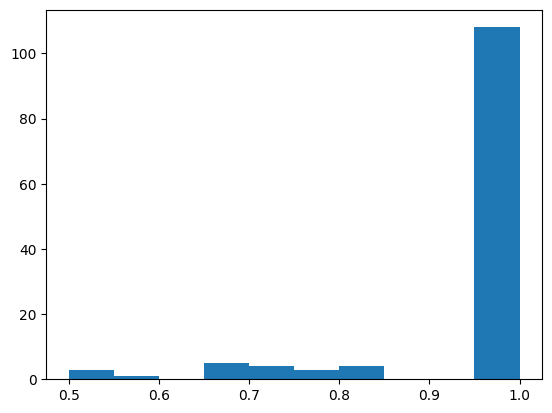

In [65]:
best_estimator.plot_confidence_histogram()

In [35]:
results = clf.cv_results_

In [36]:
results

{'mean_fit_time': array([249.91539812, 219.16717911]),
 'std_fit_time': array([28.91756701,  5.43024993]),
 'mean_score_time': array([0.32185006, 0.16234255]),
 'std_score_time': array([0.01697397, 0.10468745]),
 'param_claim_column_name': masked_array(data=['Text', 'Text'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_k': masked_array(data=[15, 15],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_cluster_size': masked_array(data=[5, 5],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_dist': masked_array(data=[0, 0],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples': masked_array(data=[1, 1],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_n_neighbors': masked_array(data=[348, 348],
              mask=[False, False],
        fill_val

In [29]:
ground_truth_df, cluster_counts = best_estimator.report_ground_truth_data(True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vinayakkannan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


heat
argument
scientists
grid
corrupted
daylight
exaggerate
meat
agreement
way
passed
called
going
threat
acid
denying
hot
denies
arsonists
took
human
hoax
wildfires
cycle
reef
biggest
lockdowns
activity
faked
warming
manhattan
arctic
article
happening
lion
socially
epa
greta
lockdown
field
asymptomatic
level
shows
sky
video
stress
absorbed
permafrost
grow
lyme
workers
geography
impacts
transportation
fish
strategies
albert
cnn
map
jets
haarp
animal
aphelion
april
million
period
urban
concentrations
dec
health
biden
gates
goal
households
continue
trudeau
co
co
co
kilt
primary
exposure
chemtrails
concedes
created
greta
vowed
scam
increase
hundreds
affect
moon
influence
yard
coasts
companies
heat
billion
differences
disha
periods
warmed
solar
warming
flooding
example
water
scientific
severity
deaths
trump
hurricane
bus
transportation
band
bridges
land
energy
square
tenths
risen
natural
worth
greta
warms
cash
earlier
dioxide
cruz
carolina
economy
southwest
live
income
water
risk
assessmen

In [30]:
ground_truth_df

,cluster,claim,veracity,tfidf_top_3,cluster_label
0,-1,"""...the earth moves closer to the sun every ye...",1.0,"heat, percent, epa, earth, infants","Climate change impacts on health, infants, and..."
1,31,"""11 straight years of no major hurricanes stri...",1.0,"argument, bores, hole, straight, striking",Impact of hurricane frequency on climate chang...
2,86,"""30,000 scientists have come forward confirmin...",1.0,"scientists, signed, arguing, confirming, convi...",Claiming scientists argue man-made climate cha...
3,75,"""70 per cent of Australia's trade [is] now wit...",3.0,"grid, electric, gigawatts, onto, operates",Electric grid transitions to renewable energy ...
4,0,"""96 percent of US climate data is corrupted""",1.0,"corrupted, data, percent, us, climate","""High percentage of corrupted climate data in ..."
...,...,...,...,...,...
634,10,“The reality is more people are dying of bad c...,1.0,"died, dying, elizabeth, ii, policies",Climate change impacts on death and Queen Eliz...
635,158,“We have been cooling down for the past 4000 y...,1.0,"biggest, years, since, drop, talk",Earth cooling claims based on historical tempe...
636,11,“… 600 million Africans lack access to electri...,3.0,"access, africa, million, accommodate, advanced","Africa's challenges with access, millions of p..."
637,75,“… with 93% of that power being renewable.”,1.0,"grid, electric, gigawatts, onto, operates",Electric grid transitions to renewable energy ...


In [28]:
cluster_counts

,cluster,count_false,count_true
0,-1,41,46
1,31,3,0
2,86,3,0
3,75,1,3
4,0,3,0
...,...,...,...
178,21,0,2
179,105,2,0
180,138,2,0
181,161,2,0


In [31]:
ground_truth_df
ground_truth_df.to_csv("ground_truth_df.csv")

In [32]:
cluster_counts
cluster_counts.to_csv("cluster_counts.csv")

In [69]:
ground_truth_df

,cluster,claim,veracity,tfidf_top_3,cluster_label
0,0,"""...the earth moves closer to the sun every ye...",1.0,"co, change, global, said, climate",Controversial claims on global climate change ...
1,0,"""30,000 scientists have come forward confirmin...",1.0,"co, change, global, said, climate",Controversial claims on global climate change ...
2,0,"""96 percent of US climate data is corrupted""",1.0,"co, change, global, said, climate",Controversial claims on global climate change ...
3,0,"""Antarctica has had to update its flag""due to ...",1.0,"co, change, global, said, climate",Controversial claims on global climate change ...
4,0,"""Biden's climate requirements"" will ""cut 90% o...",1.0,"co, change, global, said, climate",Controversial claims on global climate change ...
...,...,...,...,...,...
506,0,“The amount of coral on the Great Barrier Reef...,1.0,"co, change, global, said, climate",Controversial claims on global climate change ...
507,5,“The clothing industry contributes up to 10% o...,3.0,"income, access, grid, households, electric",Impact of income and access on household elect...
508,0,“We have been cooling down for the past 4000 y...,1.0,"co, change, global, said, climate",Controversial claims on global climate change ...
509,5,“… 600 million Africans lack access to electri...,3.0,"income, access, grid, households, electric",Impact of income and access on household elect...
